# Using Statistics to Identify Spam
## MSDS 7333 - Section 401
## Case Study Week 8
[Data Science @ Southern Methodist University](https://datascience.smu.edu/)

### Due:
23 July 2018

### Table of Contents
* [Team Members](#Team-Members)
* [Abstract](#Abstract)
* [Introduction](#Introduction)
* [Methods](#Methods)
* [Results](#Results)
* [Conclusion](#Conclusion)
* [References](#References)

### <a name="Team-Members"></a>Team Members
* Kevin Cannon
* Austin Hancock

### <a name="Abstract"></a>Abstract

Use set of classified SpamAssassin email messages to develop and test a spam filter by applying a recursive partitioning method to build a decision tree. This notebook answers [Exercise #3.19](http://www.rdatasciencecases.org/exercises.html#chap:Spam) in the Nolan and Lang reference.

### <a name="Introduction"></a>Introduction

With the extensive use of the internet, email is used as an efficient method of communication today. Unfortunately, spam email messages have infected email platforms, cluttering the inboxes of users with junk email. Like junk paper mail, spam emails negatively impact the delivery of legitimate and important email traffic.

Spam can be defined as unsolicited and unwanted email that was sent in bulk by a sender with no relation to the recipient. Since so much information is stored in text form, like emails, text mining and text analysis has become an important way to examine data. One important application of text mining is spam filtering.

Spam filters classify incoming messages based on the contents of the email and other predefined attributes. Many spam filtering techniques work by searching for patterns in the header and body of email messages. While humans can often easily determine a spam message after a close reading, computer programs can struggle to identify the messages to filter. The decision to classify the email as spam is based on a statistical analysis of emails that have been previously classified as spam, or unwanted messages, or ham, which are wanted messages.

For this analysis, we will be using public data from the Apache SpamAssassin data set. Over 9,000 emails have been classified by hand to determine desirability. The email messages were classified by spam or ham and by how difficult the message was to classify.

Apache SpamAssassin is an open source anti-spam platform giving system administrators a filter to classify email and block spam (unsolicited bulk email). It uses a robust scoring framework and plug-ins to integrate a wide range of advanced heuristic and statistical analysis tests on email headers and body text including text analysis, Bayesian filtering, DNS blocklists, and collaborative filtering databases.

The analysis in this case study follows the analysis in the Nolan and Lang [1] textbook, where the authors process the emails, derive and explore the variables for analysis, and apply a recursive partitioning method to build a decision tree from the derived set of features. The focus of the lab will be to use the cleaned data set to explore the parameters that control the recursive partitioning process. Specifically, the lab centers around [Exercise #3.19](http://www.rdatasciencecases.org/exercises.html#chap:Spam), which has the following instructions:
> Consider the other parameters that can be used to control the recursive partitioning process. Read the documentation for them in the rpart.control() documentation. Also, carry out an Internet search for more information on how to tweak the rpart() tuning parameters. Experiment with values for these parameters. Do the trees that result make sense with your understanding of how the parameters are used? Can you improve the prediction using them?

### <a name="Methods"></a>Methods

Before we can inspect how the rpart control parameters effect the error rates and decision tree structure, we first need a clean dataset to work with. Since we are only interested in exploring this particular function, we have already completed the data preperation process in another workbook. Below, we load in this data and split it into test and training sets for our model.

#### Load Saved Clean Data

In [7]:
library(rpart.plot)
library("IRdisplay")
load("spamAssassinDerivedDF.rda")

In [8]:
setupRpart = function(data) {
  logicalVars = which(sapply(data, is.logical))
  facVars = lapply(data[ , logicalVars], 
                   function(x) {
                      x = as.factor(x)
                      levels(x) = c("F", "T")
                      x
                   })
  cbind(facVars, data[ , - logicalVars])
}

# Apply function to our data frame
emailDFrp = setupRpart(emailDF)

In [13]:
numEmail = 9348
numSpam = 2397
numHam = 6951

In [14]:
# Split into training and test sets
set.seed(418910)
testSpamIdx = sample(numSpam, size = floor(numSpam/3))
testHamIdx = sample(numHam, size = floor(numHam/3))

# Use these indices to select the rows of the data frame
testDF = 
  rbind( emailDFrp[ emailDFrp$isSpam == "T", ][testSpamIdx, ],
         emailDFrp[emailDFrp$isSpam == "F", ][testHamIdx, ] )
trainDF =
  rbind( emailDFrp[emailDFrp$isSpam == "T", ][-testSpamIdx, ], 
         emailDFrp[emailDFrp$isSpam == "F", ][-testHamIdx, ])

In [15]:
# Fit the classification tree
rpartFit = rpart(isSpam ~ ., data = trainDF, method = "class")

F    T 
2185  132

[1] 0.05697022

[1] 0.1652065

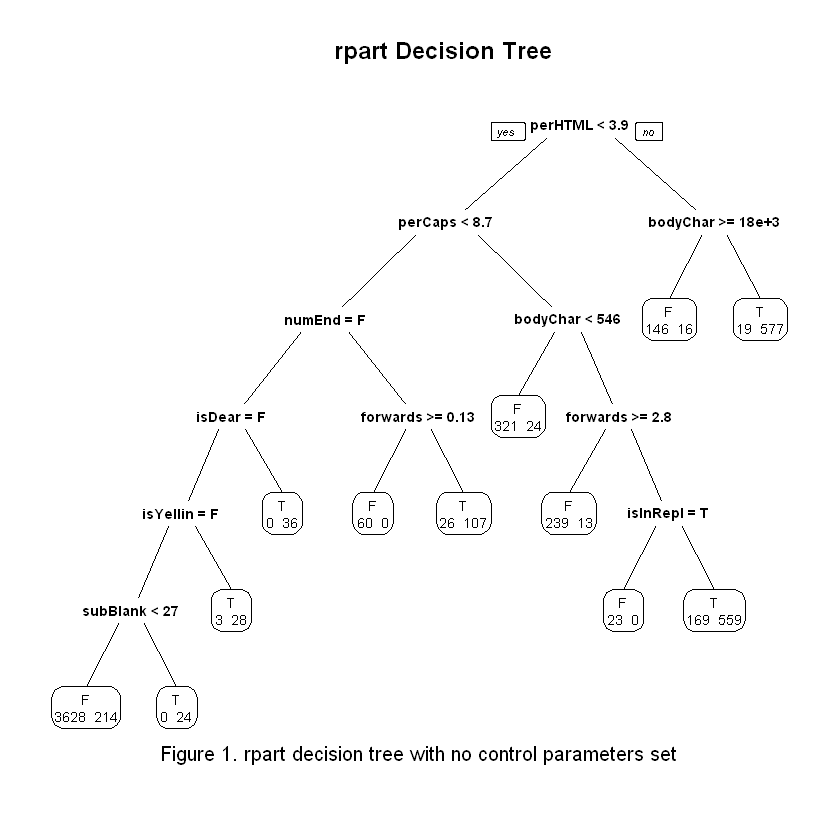

In [89]:

prp(rpartFit, extra = 1)
title("rpart Decision Tree")
mtext(text="Figure 1. rpart decision tree with no control parameters set", side = 1, line = 1)


# How does the classifier do a predicting whether a message is spam or ham
predictions = predict(rpartFit, 
       newdata = testDF[, names(testDF) != "isSpam"],
       type = "class") 
predsForHam = predictions[ testDF$isSpam == "F" ]
summary(predsForHam)

# Type I Error
sum(predsForHam == "T") / length(predsForHam)

# Type II Error
predsForSpam = predictions[ testDF$isSpam == "T" ]
sum(predsForSpam == "F") / length(predsForSpam)

> The rpart decision tree in Figure 1 displays our node split elements and spam/ham counts using the rpart control default parameters. We will use this tree structure as our baseline to explore how different parameter values effect the decision tree model.

#### Minsplit

The minsplit parameter sets the minimum observations that must exist in a node in order for a split to be attempted [2].
Setting the parameter allows you to place a stop on node splits. 

In [105]:
# Let's explore the minsplit variable
# Minsplit is the minimum number of observations that must exist...
# ...in a node in order for a split to be attempted
numSplits = c(1:100)

fits = lapply(numSplits, function(x) {
         rpartObj = rpart(isSpam ~ ., data = trainDF,
                          method="class", 
                          control = rpart.control(minsplit=x) )
           
         predict(rpartObj, 
                 newdata = testDF[ , names(testDF) != "isSpam"],
                 type = "class")
        })

spam = testDF$isSpam == "T"
numSpam = sum(spam)
numHam = sum(!spam)
errs = sapply(fits, function(preds) {
                      typeI = sum(preds[ !spam ] == "T") / numHam
                      typeII = sum(preds[ spam ] == "F") / numSpam
                      c(typeI = typeI, typeII = typeII)
                     })

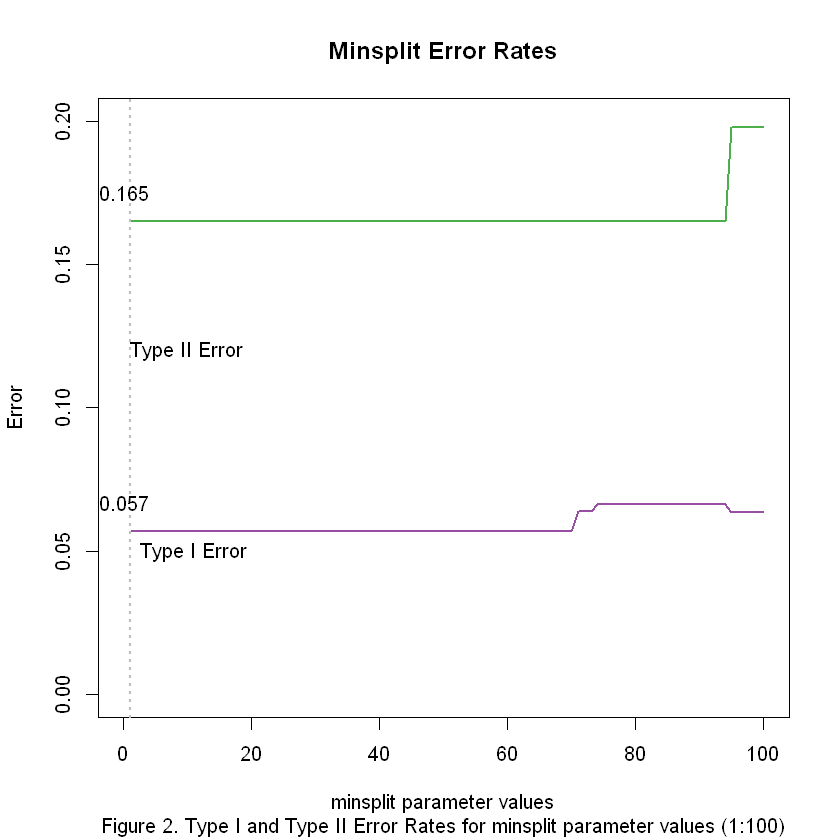

In [106]:
cols = brewer.pal(9, "Set1")[c(3, 4, 5)]
plot(errs[1,] ~ numSplits, type="l", col=cols[2], 
     lwd = 2, ylim = c(0,0.2), xlim = c(0,100), 
     ylab="Error", xlab="minsplit parameter values")
points(errs[2,] ~ numSplits, type="l", col=cols[1], lwd = 2)

text(x =c(10, 11), y = c(0.12, 0.05), 
     labels=c("Type II Error", "Type I Error"))

minI = which(errs[1,] == min(errs[1,]))[1]
abline(v = numSplits[minI], col ="grey", lty =3, lwd=2)

text(0.0007, errs[1, minI]+0.01, 
     formatC(errs[1, minI], digits = 2))
text(0.0007, errs[2, minI]+0.01, 
     formatC(errs[2, minI], digits = 3))
title("Minsplit Error Rates")
mtext(text="Figure 2. Type I and Type II Error Rates for minsplit parameter values (1:100)", side = 1, line = 4)

> Figure 2 shows an increase in Type I Error rates beginning around a minsplit value of 70. To find the value at which this change occurs, we will print out the error rates between minsplit values of 60 to 100 and then build our decision tree model.

In [107]:
print(errs[,60:100])

             [,1]       [,2]       [,3]       [,4]       [,5]       [,6]
typeI  0.05697022 0.05697022 0.05697022 0.05697022 0.05697022 0.05697022
typeII 0.16520651 0.16520651 0.16520651 0.16520651 0.16520651 0.16520651
             [,7]       [,8]       [,9]      [,10]      [,11]     [,12]
typeI  0.05697022 0.05697022 0.05697022 0.05697022 0.05697022 0.0638757
typeII 0.16520651 0.16520651 0.16520651 0.16520651 0.16520651 0.1652065
           [,13]     [,14]      [,15]      [,16]      [,17]      [,18]
typeI  0.0638757 0.0638757 0.06646526 0.06646526 0.06646526 0.06646526
typeII 0.1652065 0.1652065 0.16520651 0.16520651 0.16520651 0.16520651
            [,19]      [,20]      [,21]      [,22]      [,23]      [,24]
typeI  0.06646526 0.06646526 0.06646526 0.06646526 0.06646526 0.06646526
typeII 0.16520651 0.16520651 0.16520651 0.16520651 0.16520651 0.16520651
            [,25]      [,26]      [,27]      [,28]      [,29]      [,30]
typeI  0.06646526 0.06646526 0.06646526 0.06646526 0.0664652

png 
  2

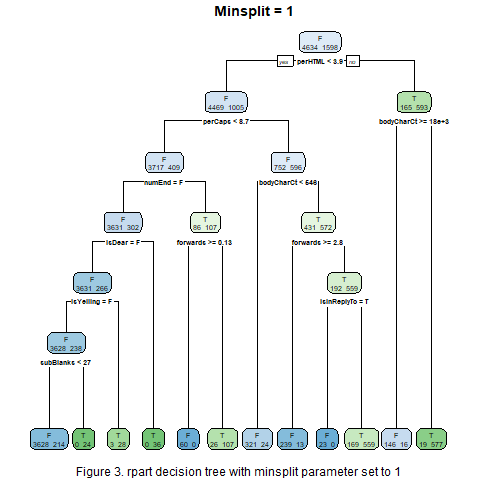

png 
  2

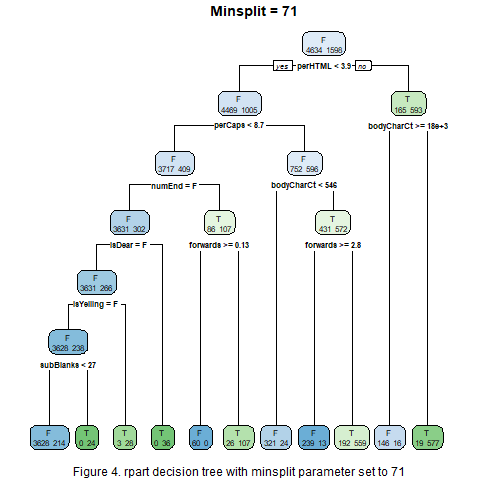

In [95]:
# Error changes at 71
# Lets compare plots
## Baseline plot
rpart1 = rpart(isSpam ~ ., data = trainDF,
                          method="class", 
                          control = rpart.control(minsplit=1) )
png("minsplit1.png")
rpart.plot(rpart1, extra=1)
title("Minsplit = 1", line = 3)
mtext(text="Figure 3. rpart decision tree with minsplit parameter set to 1", side = 1, line = 4)
dev.off()
display_png(file="minsplit1.png")

## Error rate change at minsplit = 71
rpart71 = rpart(isSpam ~ ., data = trainDF,
                          method="class", 
                          control = rpart.control(minsplit=71) )
png("minsplit71.png")
rpart.plot(rpart71, extra=1)
title("Minsplit = 71", line = 3)
mtext(text="Figure 4. rpart decision tree with minsplit parameter set to 71", side = 1, line = 4)
dev.off()
display_png(file="minsplit71.png")

> To see how the tree is affected by changing the minsplit parameter, we output one tree with a minsplit value of 1 (figure 3) and another tree with a minsplit value of 71 (figure 4) (71 because this is the first minimum value which caused a change in our error rates). From the resulting tree, we see that the IsInReplyTo element is removed when changing the minsplit parameter to 71. This is as expected. When changing only the minsplit parameter and not also changing the minbucket parameter in the rplot controls, the minbucket parameter is given the default value of minsplit/3. Since our minsplit value was 71, the minbucket value is ~ 24. With a False side split count of 23, we assumed that the IsInReplyTo node would be dropped from our tree. 

#### Minbucket

The minbucket parameter sets the minimum number of observations in any terminal <leaf> node. If only one of minbucket or minsplit is specified, the code either sets minsplit to minbucket*3 or minbucket to minsplit/3 [2].

In [108]:
# Let's explore the minbucket variable
# Minbucket sets the minimum number of observations in any terminal <leaf> node
numBucket = c(1:100)

fits = lapply(numBucket, function(x) {
         rpartObj = rpart(isSpam ~ ., data = trainDF,
                          method="class", 
                          control = rpart.control(minbucket=x) )
           
         predict(rpartObj, 
                 newdata = testDF[ , names(testDF) != "isSpam"],
                 type = "class")
        })

spam = testDF$isSpam == "T"
numSpam = sum(spam)
numHam = sum(!spam)
errs = sapply(fits, function(preds) {
                      typeI = sum(preds[ !spam ] == "T") / numHam
                      typeII = sum(preds[ spam ] == "F") / numSpam
                      c(typeI = typeI, typeII = typeII)
                     })

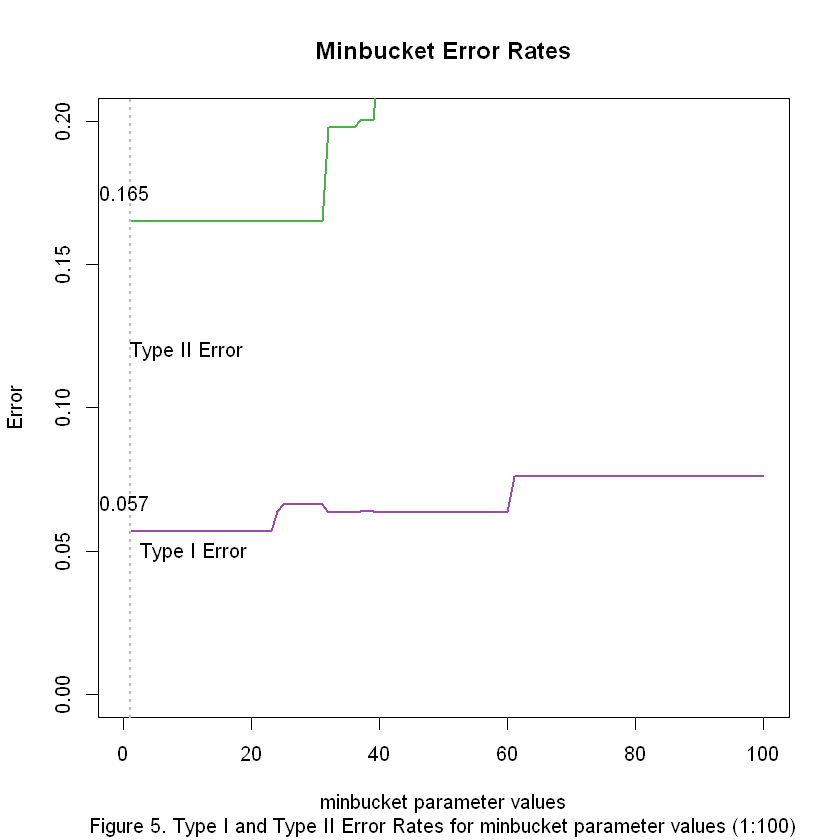

In [109]:
cols = brewer.pal(9, "Set1")[c(3, 4, 5)]
plot(errs[1,] ~ numBucket, type="l", col=cols[2], 
     lwd = 2, ylim = c(0,0.2), xlim = c(0,100), 
     ylab="Error", xlab="minbucket parameter values")
points(errs[2,] ~ numBucket, type="l", col=cols[1], lwd = 2)

text(x =c(10, 11), y = c(0.12, 0.05), 
     labels=c("Type II Error", "Type I Error"))

minI = which(errs[1,] == min(errs[1,]))[1]
abline(v = numBucket[minI], col ="grey", lty =3, lwd=2)

text(0.0007, errs[1, minI]+0.01, 
     formatC(errs[1, minI], digits = 2))
text(0.0007, errs[2, minI]+0.01, 
     formatC(errs[2, minI], digits = 3))
title("Minbucket Error Rates")
mtext(text="Figure 5. Type I and Type II Error Rates for minbucket parameter values (1:100)", side = 1, line = 4)

> The rates returned in figure 5 show changes in our Type I errors between minbucket values 20 to 65. From the error results output below, we see that these increases occur at minbucket values of 24 and 61.

In [110]:
print(errs[,20:65])

             [,1]       [,2]       [,3]       [,4]      [,5]       [,6]
typeI  0.05697022 0.05697022 0.05697022 0.05697022 0.0638757 0.06646526
typeII 0.16520651 0.16520651 0.16520651 0.16520651 0.1652065 0.16520651
             [,7]       [,8]       [,9]      [,10]      [,11]      [,12]
typeI  0.06646526 0.06646526 0.06646526 0.06646526 0.06646526 0.06646526
typeII 0.16520651 0.16520651 0.16520651 0.16520651 0.16520651 0.16520651
            [,13]      [,14]      [,15]      [,16]      [,17]     [,18]
typeI  0.06344411 0.06344411 0.06344411 0.06344411 0.06344411 0.0638757
typeII 0.19774718 0.19774718 0.19774718 0.19774718 0.19774718 0.2002503
           [,19]     [,20]      [,21]      [,22]      [,23]      [,24]
typeI  0.0638757 0.0638757 0.06344411 0.06344411 0.06344411 0.06344411
typeII 0.2002503 0.2002503 0.22528160 0.22528160 0.22528160 0.22528160
            [,25]      [,26]      [,27]      [,28]      [,29]      [,30]
typeI  0.06344411 0.06344411 0.06344411 0.06344411 0.06344411 0

png 
  2

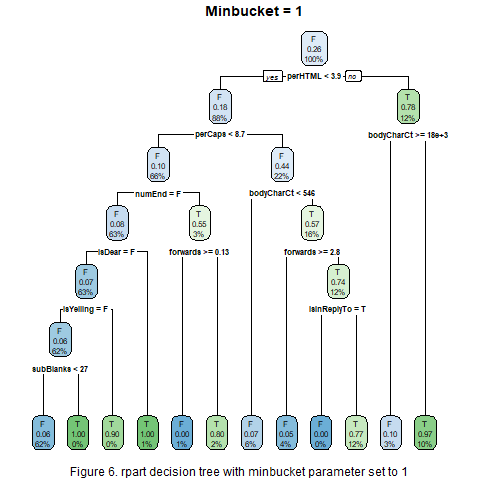

png 
  2

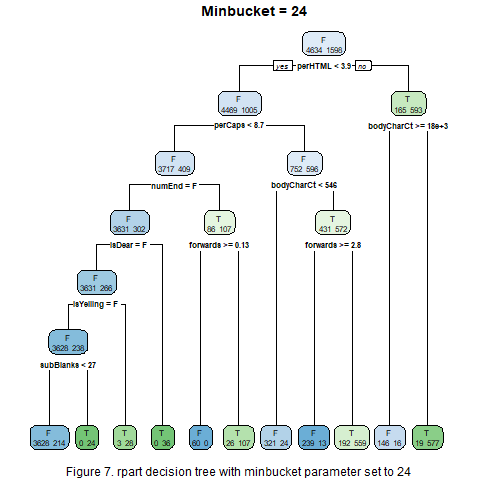

png 
  2

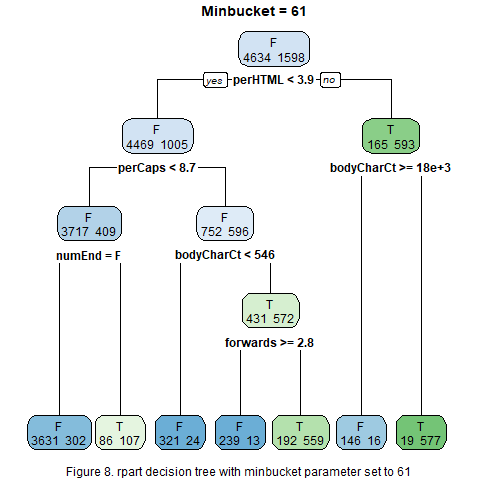

In [111]:
# Error changes at 24 and 61
# Lets compare plots
## Baseline
rpart1 = rpart(isSpam ~ ., data = trainDF,
                          method="class", 
                          control = rpart.control(minbucket=1) )
png("minbucket1.png")
rpart.plot(rpart1)
title("Minbucket = 1", line = 3)
mtext(text="Figure 6. rpart decision tree with minbucket parameter set to 1", side = 1, line = 4)
dev.off()
display_png(file="minbucket1.png")

## Minbucket = 24
rpart24 = rpart(isSpam ~ ., data = trainDF,
                          method="class", 
                          control = rpart.control(minbucket=24) )
png("minbucket24.png")
rpart.plot(rpart24, extra=1)
title("Minbucket = 24", line = 3)
mtext(text="Figure 7. rpart decision tree with minbucket parameter set to 24", side = 1, line = 4)
dev.off()
display_png(file="minbucket24.png")

## Minbucket = 61
rpart61 = rpart(isSpam ~ ., data = trainDF,
                          method="class", 
                          control = rpart.control(minbucket=61) )
png("minbucket61.png")
rpart.plot(rpart61, extra=1)
title("Minbucket = 61", line = 3)
mtext(text="Figure 8. rpart decision tree with minbucket parameter set to 61", side = 1, line = 4)
dev.off()
display_png(file="minbucket61.png")

> As with the minsplit = 71 parameter value, we see that setting minbucket = 24 removes the IsInReplyTo element (Figure 7). We would expect to see this when setting only either minbucket or minsplit as they will derive their values from each other. To see how minbucket would perform under a new circumstance, we set minbucket = 61 (this was the next increase in our Type I Error Rate). The resulting tree again returned the results we would expect given that the elements which were removed contained terminal nodes with less than 61 observations (Figure 8).

#### Complexity 

The complexity (cp) parameter sets the cutoff for any split that does not decrease the overall lack of fit [2]. This parameter can save computation time by eliminating splits which would not be worthwile to make.

In [112]:
# Let's explore the complexity parameter
complexityVals = c(seq(0.00001, 0.0001, length=19),
                   seq(0.0001, 0.001, length=19), 
                   seq(0.001, 0.005, length=9),
                   seq(0.005, 0.01, length=9))

In [113]:
fits = lapply(complexityVals, function(x) {
         rpartObj = rpart(isSpam ~ ., data = trainDF,
                          method="class", 
                          control = rpart.control(cp=x) )
           
         predict(rpartObj, 
                 newdata = testDF[ , names(testDF) != "isSpam"],
                 type = "class")
        })

spam = testDF$isSpam == "T"
numSpam = sum(spam)
numHam = sum(!spam)
errs = sapply(fits, function(preds) {
                      typeI = sum(preds[ !spam ] == "T") / numHam
                      typeII = sum(preds[ spam ] == "F") / numSpam
                      c(typeI = typeI, typeII = typeII)
                     })

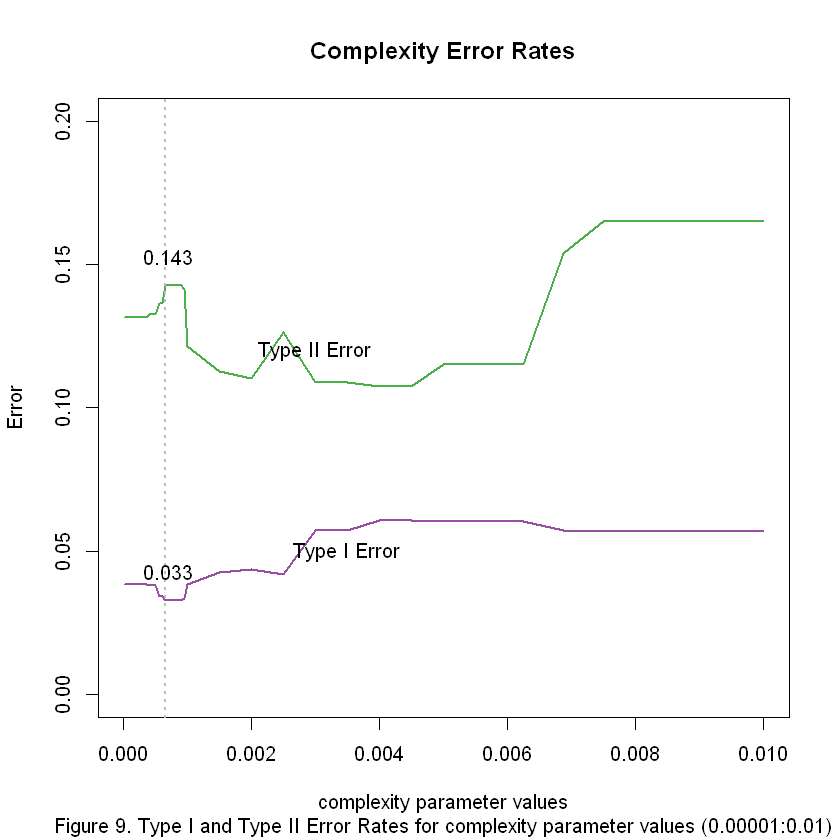

In [114]:
library(RColorBrewer)
cols = brewer.pal(9, "Set1")[c(3, 4, 5)]
plot(errs[1,] ~ complexityVals, type="l", col=cols[2], 
     lwd = 2, ylim = c(0,0.2), xlim = c(0,0.01), 
     ylab="Error", xlab="complexity parameter values")
points(errs[2,] ~ complexityVals, type="l", col=cols[1], lwd = 2)

text(x =c(0.003, 0.0035), y = c(0.12, 0.05), 
     labels=c("Type II Error", "Type I Error"))

minI = which(errs[1,] == min(errs[1,]))[1]
abline(v = complexityVals[minI], col ="grey", lty =3, lwd=2)

text(0.0007, errs[1, minI]+0.01, 
     formatC(errs[1, minI], digits = 2))
text(0.0007, errs[2, minI]+0.01, 
     formatC(errs[2, minI], digits = 3))
title("Complexity Error Rates")
mtext(text="Figure 9. Type I and Type II Error Rates for complexity parameter values (0.00001:0.01)", side = 1, line = 4)

> Unlike our previous rpart control parameters, the complexity parameter produces a varying range of error rates (figure 9). To investigate how these cp values effect our decision tree structure we will produce plots that encompass this range.

In [115]:
print(errs)

             [,1]       [,2]       [,3]       [,4]       [,5]       [,6]
typeI  0.03841174 0.03841174 0.03841174 0.03841174 0.03841174 0.03841174
typeII 0.13141427 0.13141427 0.13141427 0.13141427 0.13141427 0.13141427
             [,7]       [,8]       [,9]      [,10]      [,11]      [,12]
typeI  0.03841174 0.03841174 0.03841174 0.03841174 0.03841174 0.03841174
typeII 0.13141427 0.13141427 0.13141427 0.13141427 0.13141427 0.13141427
            [,13]      [,14]      [,15]      [,16]      [,17]      [,18]
typeI  0.03841174 0.03841174 0.03841174 0.03841174 0.03841174 0.03841174
typeII 0.13141427 0.13141427 0.13141427 0.13141427 0.13141427 0.13141427
            [,19]      [,20]      [,21]      [,22]      [,23]      [,24]
typeI  0.03841174 0.03841174 0.03841174 0.03841174 0.03841174 0.03841174
typeII 0.13141427 0.13141427 0.13141427 0.13141427 0.13141427 0.13141427
            [,25]      [,26]      [,27]      [,28]      [,29]      [,30]
typeI  0.03841174 0.03798015 0.03798015 0.03798015 

Warning message:
"labs do not fit even at cex 0.15, there may be some overplotting"

png 
  2

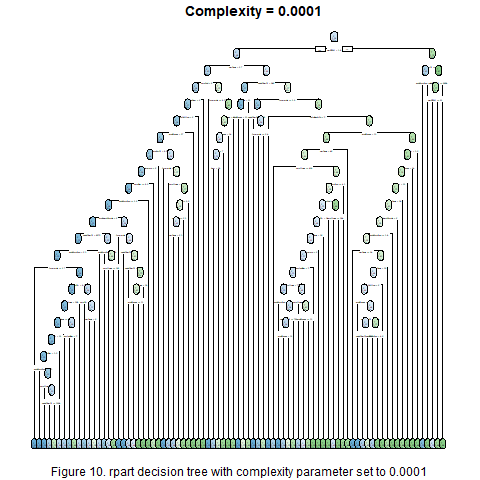

Warning message:
"labs do not fit even at cex 0.15, there may be some overplotting"

png 
  2

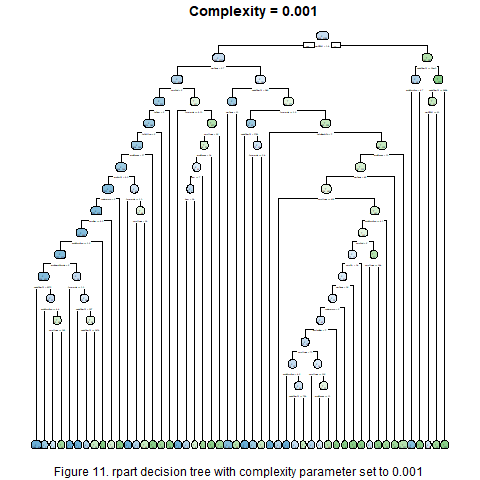

png 
  2

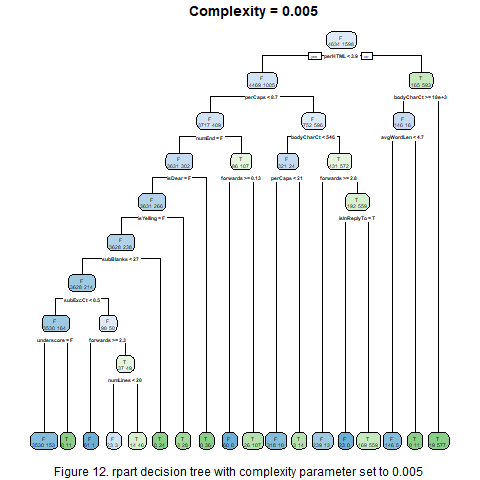

png 
  2

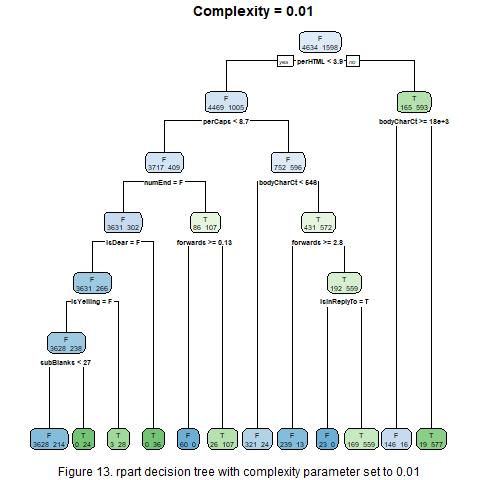

In [116]:
# Lets compare plots
rpart1 = rpart(isSpam ~ ., data = trainDF,
                          method="class", 
                          control = rpart.control(cp=0.0001) )
png("cp1.png")
rpart.plot(rpart1)
title("Complexity = 0.0001", line = 3)
mtext(text="Figure 10. rpart decision tree with complexity parameter set to 0.0001", side = 1, line = 4)
dev.off()
display_png(file="cp1.png")

rpart2 = rpart(isSpam ~ ., data = trainDF,
                          method="class", 
                          control = rpart.control(cp=0.001) )
png("cp2.png")
rpart.plot(rpart2, extra=1)
title("Complexity = 0.001", line = 3)
mtext(text="Figure 11. rpart decision tree with complexity parameter set to 0.001", side = 1, line = 4)
dev.off()
display_png(file="cp2.png")

rpart3 = rpart(isSpam ~ ., data = trainDF,
                          method="class", 
                          control = rpart.control(cp=0.005) )
png("cp3.png")
rpart.plot(rpart3, extra=1)
title("Complexity = 0.005", line = 3)
mtext(text="Figure 12. rpart decision tree with complexity parameter set to 0.005", side = 1, line = 4)
dev.off()
display_png(file="cp3.png")

rpart4 = rpart(isSpam ~ ., data = trainDF,
                          method="class", 
                          control = rpart.control(cp=0.01) )
png("cp4.png")
rpart.plot(rpart4, extra=1)
title("Complexity = 0.01", line = 3)
mtext(text="Figure 13. rpart decision tree with complexity parameter set to 0.01", side = 1, line = 4)
dev.off()
display_png(file="cp4.png")

> With the wide range of error rates, we expected the tree structure to vary between the cp values, but we did not expect what can be seen in figures 10, 11, and 12. In each of these trees, the low complexity threshold allowed a much larger number of splits than our baseline structure (Figure 13).

Notes:
The complexity parameter (cp) is used to control the size of the decision tree and to select the optimal tree size. If the cost of adding another variable to the decision tree from the current node is above the value of cp, then tree building does not continue. We could also say that tree construction does not continue unless it would decrease the overall lack of fit by a factor of cp. Setting the cp to zero will build a tree to its maximum depth.

#### Maxdepth

The maxdepth parameter sets the maximum depth of any node of the final tree [2]. It can also be described as the length of the longest path from the tree root to a leaf. The root node is considered to have a depth of 0.

In [117]:
# Let's explore the maxdepth variable
# Maxdepth sets the maximum depth of any node of the final tree
depth = c(1:10)

fits = lapply(depth, function(x) {
         rpartObj = rpart(isSpam ~ ., data = trainDF,
                          method="class", 
                          control = rpart.control(maxdepth=x) )
           
         predict(rpartObj, 
                 newdata = testDF[ , names(testDF) != "isSpam"],
                 type = "class")
        })

spam = testDF$isSpam == "T"
numSpam = sum(spam)
numHam = sum(!spam)
errs = sapply(fits, function(preds) {
                      typeI = sum(preds[ !spam ] == "T") / numHam
                      typeII = sum(preds[ spam ] == "F") / numSpam
                      c(typeI = typeI, typeII = typeII)
                     })

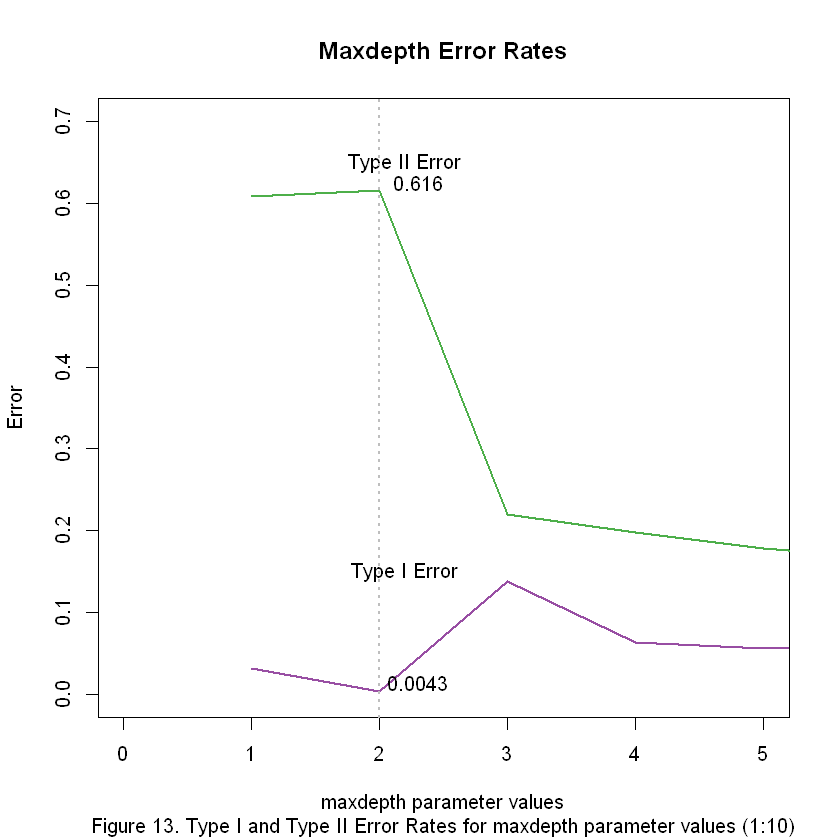

In [118]:
cols = brewer.pal(9, "Set1")[c(3, 4, 5)]
plot(errs[1,] ~ depth, type="l", col=cols[2], 
     lwd = 2, ylim = c(0,0.7), xlim = c(0,5), 
     ylab="Error", xlab="maxdepth parameter values")
points(errs[2,] ~ depth, type="l", col=cols[1], lwd = 2)

text(x =c(2.2, 2.2), y = c(0.65, 0.15), 
     labels=c("Type II Error", "Type I Error"))

minI = which(errs[1,] == min(errs[1,]))[1]
abline(v = depth[minI], col ="grey", lty =3, lwd=2)

text(2.3, errs[1, minI]+0.01, 
     formatC(errs[1, minI], digits = 2))
text(2.3, errs[2, minI]+0.01, 
     formatC(errs[2, minI], digits = 3))
title("Maxdepth Error Rates")
mtext(text="Figure 13. Type I and Type II Error Rates for maxdepth parameter values (1:10)", side = 1, line = 4)

> Figure 13 shows that the Type I error rates returned at a maxdepth value of 2 produces the lowest rate we have seen so far (0.0043) but also our highest Type II error rate (0.616). To see how this parameter effects our decision tree structure, we will build multiple structures at a maxdepth of 1, 2, and 6.

In [125]:
print(errs[,1:6])

             [,1]        [,2]      [,3]       [,4]       [,5]       [,6]
typeI  0.03150626 0.004315926 0.1381096 0.06344411 0.05697022 0.05697022
typeII 0.60826033 0.615769712 0.2202753 0.19774718 0.17897372 0.16520651


png 
  2

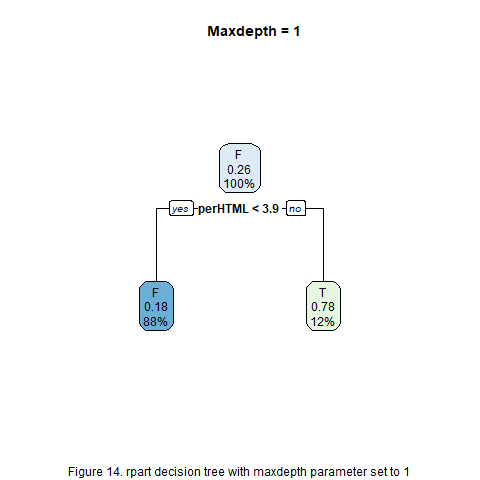

png 
  2

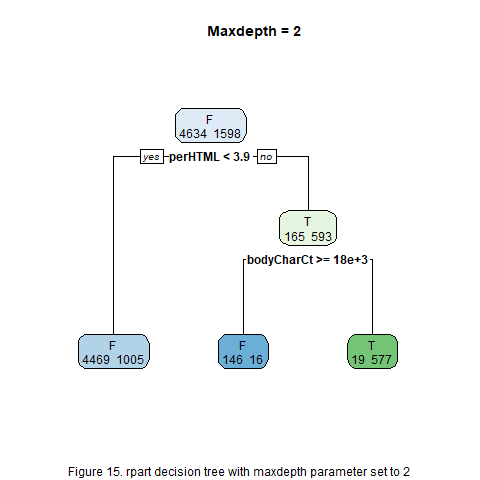

png 
  2

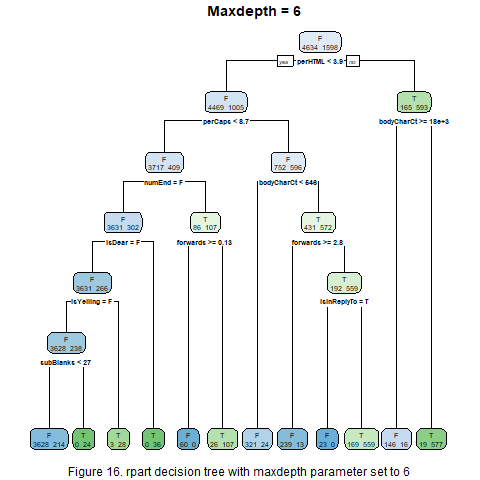

In [124]:
# Error changes at 2
# Lets compare plots
rpart1 = rpart(isSpam ~ ., data = trainDF,
                          method="class", 
                          control = rpart.control(maxdepth=1) )
png("maxdepth1.png")
rpart.plot(rpart1)
title("Maxdepth = 1")
mtext(text="Figure 14. rpart decision tree with maxdepth parameter set to 1", side = 1, line = 4)
dev.off()
display_png(file="maxdepth1.png")

rpart2 = rpart(isSpam ~ ., data = trainDF,
                          method="class", 
                          control = rpart.control(maxdepth=2) )
png("maxdepth2.png")
rpart.plot(rpart2, extra=1)
title("Maxdepth = 2")
mtext(text="Figure 15. rpart decision tree with maxdepth parameter set to 2", side = 1, line = 4)
dev.off()
display_png(file="maxdepth2.png")

rpart6 = rpart(isSpam ~ ., data = trainDF,
                          method="class", 
                          control = rpart.control(maxdepth=6) )
png("maxdepth6.png")
rpart.plot(rpart6, extra=1)
title("Maxdepth = 6", line = 3)
mtext(text="Figure 16. rpart decision tree with maxdepth parameter set to 6", side = 1, line = 4)
dev.off()
display_png(file="maxdepth6.png")

> Our tree structures formed exactly as we would expect given the maxdepth values we used to build the tree. This parameter is useful in stepping through our decision tree, element by element, and seeing how each split effects our classifications.

### <a name="Results"></a>Results

In this analysis, we were able to take a set of cleaned and prepared email messages and identify how rpart.control() parameters effect their classification. By separately tuning the parameters, we could identify how each value effects the Type I and Type II error rates and the overall structure of the decision tree.

The minsplit and minbucket parameters were rather intuitive. Changes to these parameters produced Type I errors that had a minimum floor at the lowest value for both parameters. This makes sense since these parameters set the minimum number for terminal node values (when applied individually). The tree structures produced by these two parameters matched our assumptions of what the tuning would produce. Setting their values creates a cut-off for nodes and this was displayed in the plots.

The maxdepth parameter was similarly intuitive in terms of the tree structure; it sets a stop value. With such a strict cut-off, this parameter could be useful in stepping through each level of a decision tree to see how each split effects our classification.

The parameter that we were not able to determine its error rates and tree structure, a priori, was the complexity parameter (cp). With our lowest three cp values (shown in figs. 10, 11, and 12), our decision trees ended up having more nodes than our baseline. We did not anticipate the structure adding nodes. However, since the cp value determines how useful a split is to the overall R-squared value, we understand why decreasing the cp value increases the potential number of splits. 

### <a name="Conclusion"></a>Conclusion

With rpart.control() parameters, as is the case with most parameters, it is important to understand both how to tune the values, as well as how these changes effect your model structure. Through this case study we learned; how to read, clean, and format email messages, how to build models of Type I and Type II error rates, and how tuning rpart parameters (minsplit, minbucket, cp, and maxdepth) effects decision tree structures.

While in this case study we examined each parameter and its effect on tree structure individually, in the future we could see how setting multiple parameters changes the tree structure and error rates. 

Additional exploration could investigate the use of a loss matrix. A loss matrix is used to weight mis-classifications differently. This refers to the false positives and false negatives for a two-class problem like spam filtering. Often, one type of error is more of a harmful to the user than the other type of failure, so a loss matrix can skew the predictions to account for that difference in importance.

### <a name="References"></a>References

[1] Nolan, D, and D.T. Lang. Data Science in R: A Case Studies Approach to Computational Reasoning and Problem Solving. CRC Press, 2015, books.google.com.sa/books?id=r_0YCwAAQBAJ.

[2] Package 'rpart'. (February 23, 2018). https://cran.r-project.org/web/packages/rpart/rpart.pdf